# Model Assessment for Prior Authorization Classifiers
While we are interested in models that perform well relative to quantitative measures, we would also like our model to perform well on independent test data. In other words, we seek a model that generalizes well to other data. 

We will look at bias/variance and confidence intervals for our metrics of interest (accuracy, etc).

First we load the data and introduce the models of interest.

## Load and Clean Data

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Next, we load and clean the data. Then we merge the 3 dataframes into one and then split the resulting dataframe into two. 
In the first group, we have the data corresponding to pharmacy fills in which a PA was not requested and in the second we have the data corresponding to prescriptions for which a PA was requested.  

In [183]:
# Load Data
df_date=pd.read_csv("data/dim_date.csv")
df_claim=pd.read_csv("data/dim_claims.csv")
df_pa=pd.read_csv("data/dim_pa.csv")
df_bridge=pd.read_csv("data/bridge.csv")

# Clean data so all reject_code values are integers
df_claim['reject_code'] = df_claim.reject_code.fillna(0).astype(int)

# Merge the data frames
df_main = pd.merge(df_claim, df_bridge, on='dim_claim_id')
df_main = pd.merge(df_main, df_pa, how='left', on='dim_pa_id')
df_main = pd.merge(df_main, df_date, how='left', on='dim_date_id')

# split the data frames into two -- PA requested or not
df_main_wPA = df_main[~np.isnan(df_main.pa_approved)].copy()
df_main_noPA = df_main[np.isnan(df_main.pa_approved)].copy()

Here is the dataframe corresponding to pharmacy fills with no PA requested. 

In [3]:
df_main_noPA.head()

,dim_claim_id,bin,drug,reject_code,pharmacy_claim_approved,dim_pa_id,dim_date_id,correct_diagnosis,tried_and_failed,contraindication,pa_approved,date_val,calendar_year,calendar_month,calendar_day,day_of_week,is_weekday,is_workday,is_holiday
1,2,999001,A,0,1,NaN,1,NaN,NaN,NaN,NaN,2017-01-01,2017,1,1,1,0,0,1
3,4,999001,A,0,1,NaN,1,NaN,NaN,NaN,NaN,2017-01-01,2017,1,1,1,0,0,1
4,5,417740,A,0,1,NaN,1,NaN,NaN,NaN,NaN,2017-01-01,2017,1,1,1,0,0,1
5,6,417740,A,0,1,NaN,1,NaN,NaN,NaN,NaN,2017-01-01,2017,1,1,1,0,0,1
6,7,999001,A,0,1,NaN,1,NaN,NaN,NaN,NaN,2017-01-01,2017,1,1,1,0,0,1


Here is the data frame corresponding to pharmacy fills with a PA requested.

In [87]:
df_main_wPA.head()

,dim_claim_id,bin,drug,reject_code,pharmacy_claim_approved,dim_pa_id,dim_date_id,correct_diagnosis,tried_and_failed,contraindication,pa_approved,date_val,calendar_year,calendar_month,calendar_day,day_of_week,is_weekday,is_workday,is_holiday
0,1,417380,A,75,0,1.0,1,1.0,1.0,0.0,1.0,2017-01-01,2017,1,1,1,0,0,1
2,3,417740,A,76,0,2.0,1,1.0,0.0,0.0,1.0,2017-01-01,2017,1,1,1,0,0,1
9,10,417380,A,75,0,3.0,1,0.0,0.0,1.0,1.0,2017-01-01,2017,1,1,1,0,0,1
10,11,999001,A,76,0,4.0,1,1.0,1.0,0.0,1.0,2017-01-01,2017,1,1,1,0,0,1
14,15,417614,A,70,0,5.0,1,0.0,1.0,0.0,1.0,2017-01-01,2017,1,1,1,0,0,1


Now we use one-hot encoding to turn the categorical features into binary features. There are two categorical features; the bin i.e. the payer and the drug type.

In [5]:
# encode all categorical features in the case that a PA was requested 
df_aug=df_main_wPA.copy()
df_aug['70'] = pd.get_dummies(df_aug['reject_code'])[70]
df_aug['75'] = pd.get_dummies(df_aug['reject_code'])[75]
df_aug['76'] = pd.get_dummies(df_aug['reject_code'])[76]
df_aug['bin417380']=pd.get_dummies(df_aug['bin'])[417380]
df_aug['bin999001']=pd.get_dummies(df_aug['bin'])[999001]
df_aug['bin417740']=pd.get_dummies(df_aug['bin'])[417740]
df_aug['bin417614']=pd.get_dummies(df_aug['bin'])[417614]
df_aug['drug_A']=pd.get_dummies(df_aug['drug'])['A']
df_aug['drug_B']=pd.get_dummies(df_aug['drug'])['B']
df_aug['drug_C']=pd.get_dummies(df_aug['drug'])['C']

Now we make the train-test split. We keep $20$% of the data as the test set. 

In [6]:
from sklearn.model_selection import train_test_split

# keep all except temporal features for now 
X=df_aug[['70', '75', '76', 'bin417380', 'bin999001','bin417740', 'bin417614','correct_diagnosis', 'contraindication', 'tried_and_failed', 'drug_A', 'drug_B','drug_C']]
y=df_aug[['pa_approved']]
X_train_gen,X_test_gen,y_train_gen,y_test_gen = train_test_split(X,y,
                                                test_size=.2,
                                                shuffle=True,
                                                stratify=y)

#### Models of Interest
We will analyze the following classifiers: 
1. logistic regression;
2. Bayes classifier;
3. random forests;
4. decision trees;
5. linear support vector machine; 
6. AdaBoost. 

We considered the voting classifier in some of the previous analyses. However, the analysis done here is computationally expensive and since the voting classifier performed as well as some of the other models, we choose to leave it out. 

We first import the necessary classes for the models. 

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [8]:
from collections import Counter
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin

class GroupAverageClassifier(BaseEstimator, TransformerMixin, ClassifierMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y):
        self.approved_count_ = Counter()
        self.total_count_ = Counter()
        for r, t in zip(X, y):
            g = tuple(r)
            self.approved_count_[g] += t
            self.total_count_[g] += 1
        return self
    
    def transform(self, X, y=None):
        return self.predict_proba(X)
    
    def predict(self, X):
        prob = self.predict_prob(X)
        pred = (prob > 0.5).astype(int)
        return pred
    
    def predict_prob(self, X):
        prob = np.zeros(X.shape[0])
        eps = 1e-4
        for i, r in enumerate(X):
            g = tuple(r)
            prob[i] = self.approved_count_[g] / (self.total_count_[g] + eps)
        return prob

#### Metrics of Interest 
We will be interested in accuracy, recall, precision, f1 and the area under the roc curve. 

In [378]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

In [379]:
def get_func_name(f):
    name = f.__name__
    if name.endswith('_score'):
        name = name[:-6]
    return name

default_scores = [accuracy_score, precision_score, recall_score,f1_score, roc_auc_score]
default_names = [get_func_name(f) for f in default_scores]

### Feature Importance
We will successively add in features for the models to be trained on and compare the metrics with each addition. Using the features corresponding to payer, rejection code, tried_and_failed, correct_diagnosis, contraindication and drug type, we test the importance of each feature for the above models. This will determine the order in which we successively add features to the models.

See `pa_classifier_feature_importance.ipynb` for a more in-depth analysis of feature importance. 

In [11]:
feats=['70', '75', 'bin417380','bin417740', 'bin417614','correct_diagnosis', 'contraindication', 'tried_and_failed', 'drug_A', 'drug_B']
X_train=np.array(X_train_gen[feats])
y_train=np.array(y_train_gen).ravel()
X_test=np.array(X_test_gen[feats])
y_test=np.array(y_test_gen).ravel()


models = {}

DATASETS = [(X_train, y_train), (X_test, y_test)]

def evaluate(model, name, decimal=4, score_funcs=default_scores):
    model.fit(X_train, y_train)
    scores = np.empty((2, len(score_funcs)))
    for i, (X, y) in enumerate(DATASETS):
        yhat = model.predict(X)
        for j, func in enumerate(score_funcs):
            scores[i, j] = func(y, yhat)
    scores = scores.round(decimal)
    func_names = [get_func_name(f) for f in score_funcs]
    df = pd.DataFrame(data=scores, columns=func_names, index=['train', 'test'])
    
    models[name] = (model, df)

Now we evaluate all of the models. 

In [12]:
lrc = LogisticRegression(penalty='l2', C=1)
evaluate(lrc, 'Logistic')

In [13]:
gac = GroupAverageClassifier()
evaluate(gac, 'Group Avg')

In [14]:
rfc = RandomForestClassifier()
evaluate(rfc, 'Random Forest')

In [15]:
svc = LinearSVC(penalty='l2', C=1)
evaluate(svc, 'SVC')

In [16]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
            n_estimators = 10,
            algorithm="SAMME.R",
            learning_rate = 0.5)
evaluate(ada_clf, 'AdaBoost')

In [90]:
dt_clf = DecisionTreeClassifier()
evaluate(dt_clf, 'Decision Tree')

Now we perform the permutation importance test. Recall that the values for each feature correspond to the decrease in the model's performance when the training data for that feature is randomly shuffled. In this case, we use the default score (accuracy) as the metric, so the values below represent the change in accuracy. 

In [93]:
from sklearn.inspection import permutation_importance


importances = []
model_names = []
std_devs=[]
for name, (mdl, _) in models.items():
    model_names.append(name)
    r = permutation_importance(mdl, X_train, y_train, n_repeats=10,random_state=42)
    importances.append(r['importances_mean'])
    std_devs.append(r['importances_std'])
df_importances = pd.DataFrame(data=importances,columns=feats,index=model_names)
df_std_devs=pd.DataFrame(data=std_devs,columns=feats,index=model_names)

In [95]:
cm = sns.light_palette("green", as_cmap=True)
df_importances.style.background_gradient(cmap=cm, axis=1)

,70,75,bin417380,bin417740,bin417614,correct_diagnosis,contraindication,tried_and_failed,drug_A,drug_B
Logistic,0.068399,0.025770,0.000055,0.015163,0.006082,0.000720,0.052947,0.014774,0.057061,0.014483
Group Avg,0.256223,0.291203,0.205462,0.137886,0.257261,0.001043,0.049271,0.013244,0.242212,0.206363
Random Forest,0.047564,0.014735,0.000884,0.000268,0.002306,0.001893,0.048176,0.011643,0.019209,0.001851
SVC,0.068543,0.015284,-0.000009,0.010398,0.005689,0.000904,0.047965,0.008966,0.053533,0.009504
AdaBoost,0.063948,0.019900,0.000000,-0.000727,0.000000,0.000000,0.039291,0.005728,0.010719,0.000000
Decision Tree,0.138119,0.000937,0.000676,0.001591,0.018875,0.001043,0.049271,0.013244,0.003182,0.001767


From the above table, we can construct a list of all the features in order of descending importance for each model. This will be the list from which we add features to the models and compute the new metrics. 

In [94]:
rf_features= list(df_importances.sort_values(by='Random Forest', axis=1, ascending=False).columns)
log_features=list(df_importances.sort_values(by='Logistic', axis=1, ascending=False).columns)
svc_features=list(df_importances.sort_values(by='SVC', axis=1, ascending=False).columns)
bayes_features=list(df_importances.sort_values(by='Group Avg', axis=1, ascending=False).columns)
ada_features=list(df_importances.sort_values(by='AdaBoost', axis=1, ascending=False).columns)
dt_features=list(df_importances.sort_values(by='Decision Tree', axis=1, ascending=False).columns)

## Bias, Variance and Model Complexity
Let $X$ be a feature vector, $Y$ a scalar response variable and $\epsilon$ a random variable with $\mathbb E(\epsilon) = 0$ and $\text{Var}(\epsilon) = \sigma^2$. If the relationship between $X$ and $Y$ is given by $Y = f(X) + \epsilon$, we can derive an expression for the expected prediction error of a model $\hat f$ for this relationship at feature $X = x_0$ using squared error loss as 
\begin{align*} \text{Err}(x_0) & = \mathbb E \left[\left(Y - \hat f(x_0)^2 \right) \ | \ X = x_0  \right] \\
& = \sigma^2 + \left[ \mathbb E \hat f(x_0) - f(x_0) \right]^2 + \mathbb E \left[ \hat f(x_0) - \mathbb E \hat f(x_0) \right]^2 \\
& = \sigma^2 + \text{Bias}^2 \left(\hat f(x_0) \right) + \text{Var} \left(\hat f(x_0) \right) \\
& = \text{Irreducible Error} + \text{Bias}^2 + \text{Variance}.
\end{align*}
The first term is the variance of the truth $f(x_0)$ around its true mean and cannot be made smaller. The $\text{Bias}^2$ term is the amount by which the average of our estimate differs from the true mean and the variance is the expected squared deviation of the model $\hat f(x_0)$ around its mean. 

In general, as the complexity of the model $\hat f$ increases, the squared bias will decrease and the variance will increase.

We will compute the bias, variance, and expected prediction error for each model as features are successively added. 

First we import the necessary packages and write the function that will plot the bias-variance decomposition. 

In [20]:
from mlxtend.evaluate import bias_variance_decomp
from sklearn.base import clone

In [380]:
def plot_bias_variance_decomp(bias, variance, loss, model):
    N = np.shape(bias)[1]
    plt.figure(figsize=(10,6))
    x=range(1,N+1)

    plt.plot(x, bias.reshape((-1,)),'b-o', label="Average Bias", alpha=.5)
    plt.plot(x, variance.reshape((-1,)),'r-o', label="Average Variance", alpha=.5)
    plt.plot(x, loss.reshape((-1,)),'g-o', label="Expected Prediction Error", alpha=.5)

    plt.xlabel("Number of Features",fontsize=16)
    plt.title('Bias-Variance Decomposition for PA Prediction via {}'.format(model))
    plt.xticks(np.arange(0, N+2, step=1.0))

    plt.legend(fontsize=16)

    plt.show()

In [22]:
def get_bias_var_loss(model,features):
    
    N=len(features)
    losses= np.zeros((1,N))
    biases=np.zeros((1,N))
    variances=np.zeros((1,N))
    
    for i in range(0,N):
        model_clone = clone(model)
        new_feats=features[0:i+1]
        X_train=np.array(X_train_gen.loc[:,new_feats])
        y_train=np.array(y_train_gen).ravel()

        X_test=np.array(X_test_gen.loc[:,new_feats])
        y_test=np.array(y_test_gen).ravel()
        losses[0,i],biases[0,i],variances[0,i]=\
        bias_variance_decomp(model,X_train,y_train,X_test,y_test,loss='0-1_loss',num_rounds=200)
        
    return losses, biases, variances

### Random Forests

In [23]:
forest_clf = RandomForestClassifier()
tree_losses, tree_biases, tree_variances=get_bias_var_loss(forest_clf,rf_features)

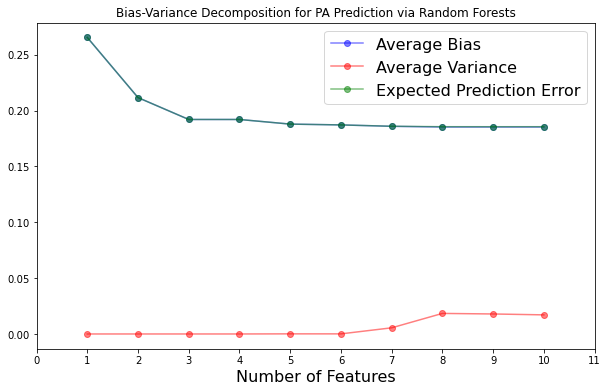

In [381]:
plot_bias_variance_decomp(tree_biases, tree_variances, tree_losses, 'Random Forests')

The variance is very low and increases once $6$ features are added. Because the variance is so low, the bias and expected prediction error visually coincide on this plot but when we print the values, we see that they do not coincide. The differences between the two are too small to be apparent from this plot. 

In [388]:
print('Average Biases:',tree_biases)
print('Expected Prediction Error', tree_losses)

Average Biases: [[0.26555207 0.2116898  0.19210188 0.19210188 0.18795586 0.18723638
  0.18597728 0.18534773 0.18534773 0.18534773]]
Expected Prediction Error [[0.26555207 0.2116898  0.19210188 0.19210188 0.18795559 0.18723233
  0.18602971 0.18562887 0.18561457 0.18562433]]


### Logistic Regression

In [25]:
log_reg = LogisticRegression()
log_losses, log_biases, log_variances=get_bias_var_loss(log_reg,log_features)

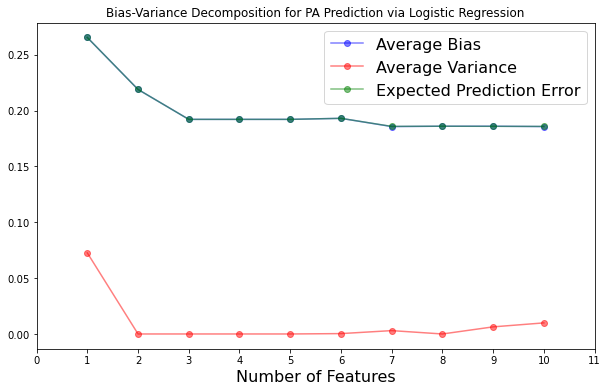

In [382]:
plot_bias_variance_decomp(log_biases, log_variances, log_losses, 'Logistic Regression')

The variance, bias, and expected prediction error decreases as the first several features are added and then start to increase when $7$ or $8$ features are added. Again, the expected prediction error and the bias are too close to be visually distinct on this plot.

### Support Vector Machines

In [27]:
svc = LinearSVC(C=1)
svc_losses, svc_biases, svc_variances=get_bias_var_loss(svc,svc_features)

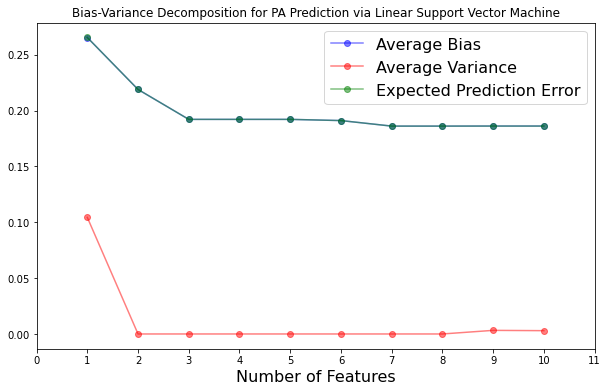

In [383]:
plot_bias_variance_decomp(svc_biases, svc_variances, svc_losses, 'Linear Support Vector Machine')

The bias, variance, and expected prediction error all decrease when the first several features are added and start to increase slowly once $9$ or $10$ features are added. 

### Bayes Classifier 

In [29]:
bayes_clf=GroupAverageClassifier()
bayes_losses, bayes_biases, bayes_variances=get_bias_var_loss(bayes_clf,bayes_features)

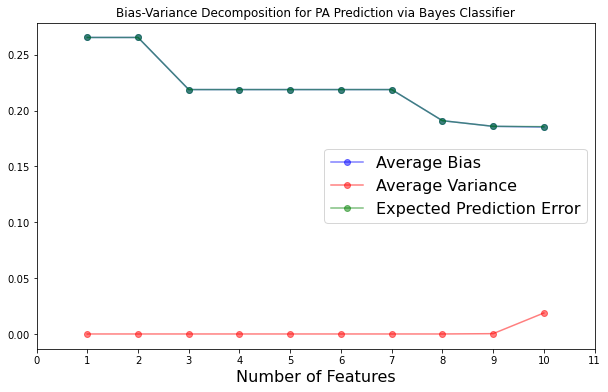

In [384]:
plot_bias_variance_decomp(bayes_biases, bayes_variances, bayes_losses, 'Bayes Classifier')

The variance for the Bayes classifier is very close to zero and starts to increase once $9$ features in the training data are used. The bias and expected prediction error start to decrease at this point.

In [391]:
print('Average Variance: ', bayes_variances)

Average Variance:  [[0.         0.         0.         0.         0.         0.
  0.         0.         0.00028586 0.01879729]]


### AdaBoost

In [31]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
            n_estimators = 10,
            algorithm="SAMME.R",
            learning_rate = 0.5
        )
ada_losses, ada_biases, ada_variances=get_bias_var_loss(ada_clf,ada_features)

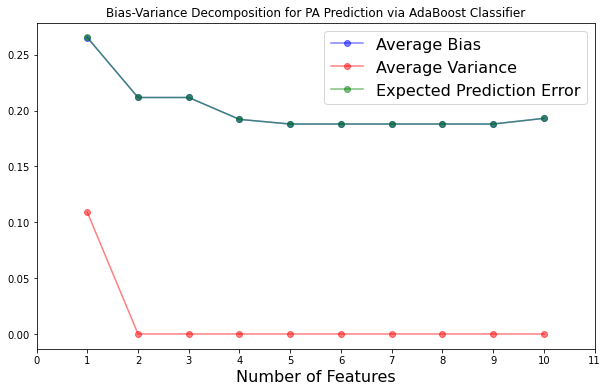

In [385]:
plot_bias_variance_decomp(ada_biases, ada_variances, ada_losses, 'AdaBoost Classifier')

The average bias, average variance, and expected prediction error decreases with the first several added features. 

### Decision Tree

In [386]:
dt_clf = DecisionTreeClassifier()
dt_losses, dt_biases, dt_variances=get_bias_var_loss(dt_clf,dt_features)

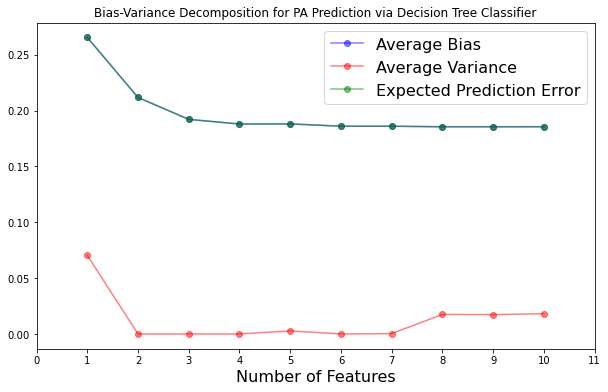

In [387]:
plot_bias_variance_decomp(dt_biases, dt_variances, dt_losses, 'Decision Tree Classifier')

The average variance decreases sharply once a second feature is added to the training data and starts to increase again once $7$ features are added. 
### Conclusions
Often, when plotting average bias, average variance and expected prediction error against model complexity, there is a clear picture of the bias variance trade off. In our analysis, this does not seem to be the case. It could be that the change in complexity of the models was not large enough to capture this change -- adding features to the training data is one way to increase complexity, but so is changing other hyperparameters. 

## Bootstrapping
This is a good method for assessing statistical accuracy. Similar to cross-validation, bootstap methods seek to estimate the expected prediction error Err and other measures of accuracy.

### Standard Bootstrap Estimates 
The general procedure for standard bootstrapping is as follows: 
1. make the train-test split so that the training set is of size N;
2. sample with replacement from the training set N times to create a bootstrapped data set;
3. train the model on the bootstrapped training data;
4. compute the error (or other measure of performance) of the model classification on the training set.

If we repeat this process B times, we can take the middle $k\%$ of the performance measures to construct a confidence interval. This method will give us a confidence interval about the measure of performance on the training set.

In this section, we repeat the process $100$ times to construct $95\%$ confidence intervals around accuracy, precision, etc. It would be better to do more repetitions, but the computational expense is prohibitive. 

In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.utils import resample

def get_func_name(f):
    name = f.__name__
    if name.endswith('_score'):
        name = name[:-6]
    return name

default_scores = [accuracy_score, precision_score, recall_score,f1_score, roc_auc_score]
default_names = [get_func_name(f) for f in default_scores]

# get the bootstrapped scores for a model. 
def get_bootstrapped_scores(model, X_train, y_train, n_bootstrap=100, scores=default_scores):
    score_data=np.empty((n_bootstrap, len(scores)))
    for i in range(0, n_bootstrap):
        X_boot, y_boot=resample(np.array(X_train), np.array(y_train).ravel(), replace=True,random_state=i)
        cloned_model=clone(model)
        cloned_model.fit(X_boot, y_boot)
        preds=cloned_model.predict(X_boot)
        for j, func in enumerate(scores):
            score_data[i, j] = func(y_boot, preds)
        if i%10 == 0: 
            print('iteration', i)
    func_names = [get_func_name(f) for f in scores]
    df = pd.DataFrame(data=score_data, columns=func_names)
    return df 

# this function computes metrics on bootstrapped samples for a changing list of features 
def seq_bootstrapped_scores(model, model_feats, X_gen, y_gen, scores=default_scores):
    cols = [get_func_name(f) for f in scores]
    cols.append("model_complexity")
    df = pd.DataFrame(columns=cols)
    for i,j in enumerate(model_feats):
        total_feats=model_feats[0:i+1]
        X,y =X_gen.loc[:,total_feats], y_gen
        i_scores=get_bootstrapped_scores(model, X,y)
        i_scores['model_complexity'] = i+1
        df=pd.concat([df, i_scores], axis= 0)
    return df

### Out-of-bag Error 
We use bootstrapping to build confidence intervals around the test error. Previously, we were building confidence intervals around the training error. The procedure for out-of-bag bootstrapping is as follows: 
1. make the train-test split so that the training set is of size $N$;
2. sample with replacement from the training set $N$ times to make a new training set;
3. any unsampled data from the original training set becomes the test set;
4. get measures of performance on this test set.

Below we write the functions that perform out-of-bag bootstrapping. We also write the functions to build the confidence intervals and plot them. 

In [34]:
from mlxtend.evaluate import BootstrapOutOfBag

In [56]:
def get_boots_oob_scores(model, X, y, n_bootstrap=100, scores=default_scores):
    score_data=np.empty((n_bootstrap, len(scores)))
    oob=BootstrapOutOfBag(n_splits=n_bootstrap, random_seed=101)
    N=len(X)
    i=0
    for train_split, test_split in oob.split(np.array(range(0,N))):
        X_train =np.array(X.iloc[train_split])
        y_train= np.array(y.iloc[train_split]).ravel()
        X_test, y_test=X.iloc[test_split], y.iloc[test_split]
        
        cloned_model=clone(model)
        cloned_model.fit(X_train, y_train)
        test_preds=cloned_model.predict(X_test)
        for j, func in enumerate(scores):
            score_data[i, j] = func(y_test, test_preds)
            func_names = [get_func_name(f) for f in scores]
            df = pd.DataFrame(data=score_data, columns=func_names)
        i+=1
        if i%10 == 0: 
            print('iteration', i)
    return df

def seq_oob_scores(model, model_feats, X_gen, y_gen, scores=default_scores):
    cols = [get_func_name(f) for f in scores]
    cols.append("model_complexity")
    df = pd.DataFrame(columns=cols)
    for i,j in enumerate(model_feats):
        total_feats=model_feats[0:i+1]
        X,y =X_gen.loc[:,total_feats], y_gen
        i_scores=get_boots_oob_scores(model, X,y)
        i_scores['model_complexity'] = i+1
        df=pd.concat([df, i_scores], axis= 0)
    return df 

In [217]:
# the data frame will contain all score types (accuracy, prec, etc) that's returned from get_bootstrapped_scores() 
def create_ci(df, alpha, scores=default_scores):
    new_df = pd.DataFrame(columns=['lower_bound', 'middle', 'upper_bound', 'model_complexity', 'score_type'])
    x=range(1,df[['model_complexity']].nunique()[0]+1)
    num_scores=np.shape(df)[1]-1    
    for level in x:
        # extract bootstrap samples cooresponding to model complexity level and then drop that column so only the data remains
        con_ints=np.zeros((num_scores,4))
        df_small=df[df['model_complexity']==level].drop('model_complexity', axis = 1)
        for i,j in enumerate(df_small.columns):
            data=np.array(df_small[j])
            p = ((1.0-alpha)/2.0) * 100
            con_ints[i,0] = max(0.0, np.percentile(data, p))
            p = (alpha+((1.0-alpha)/2.0)) * 100
            con_ints[i,1]=np.percentile(data, 50)
            con_ints[i,2] = min(1.0, np.percentile(data, p))
            con_ints[:,3]=level
            
        func_names = [get_func_name(f) for f in scores]
        level_df = pd.DataFrame(data=con_ints, columns=['lower_bound', 'middle', 'upper_bound', 'model_complexity'])
        level_df['score_type']=func_names
        new_df=pd.concat([new_df, level_df], axis=0)
    return new_df

# the data frames have a column for each score and a column for the model complexity 

def plot_ci(df, model, set_type, features, scores=default_names):
    N = df[['model_complexity']].nunique()[0] # types of scores
    x=range(1,N+1)
    fig, ax = plt.subplots(figsize=(14,10))
 
    colors=['tab:blue', 'tab:red', 'tab:green', 'tab:orange', 'tab:purple']
    for i,j in enumerate(scores):
        data=df[df['score_type']==j]
        midvals=np.array(data[['middle']])
        ub=np.array(data[['upper_bound']])
        lb=np.array(data[['lower_bound']])
        ax.plot(features, np.reshape(midvals,(-1,)), 'o-', color=colors[i])
        ax.plot(features, np.reshape(ub,(-1,)), '-',alpha=.2, color=colors[i])
        ax.plot(features, np.reshape(lb,(-1,)), '-',alpha=.2, color=colors[i])
        ax.fill_between(features, np.reshape(lb,(-1,)), np.reshape(ub,(-1,)), alpha=.2, label=j, color=colors[i])

    ax.set_xlabel("Features Added",fontsize=16)
    ax.set_title('Confidence Intervals for PA Prediction on the {} set via {}'.format(set_type,model))
    ax.tick_params(axis='x', rotation=70)
    ax.set_xticks(np.arange(0, N+3, step=1.0))
   

    ax.legend(fontsize=16)

    plt.show()

We set alpha here. This determines the level of the confidence interval. 

In [37]:
alpha=.95

### Random Forests
We first take $100$ bootstrap samples from the data and train the random forest classifier on these samples. We must do this for all combinations of features we are interested in. 

In [83]:
rf_clf = RandomForestClassifier()
rf_b_scores=seq_bootstrapped_scores(rf_clf, rf_features, X_train_gen, y_train_gen)

iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iterati

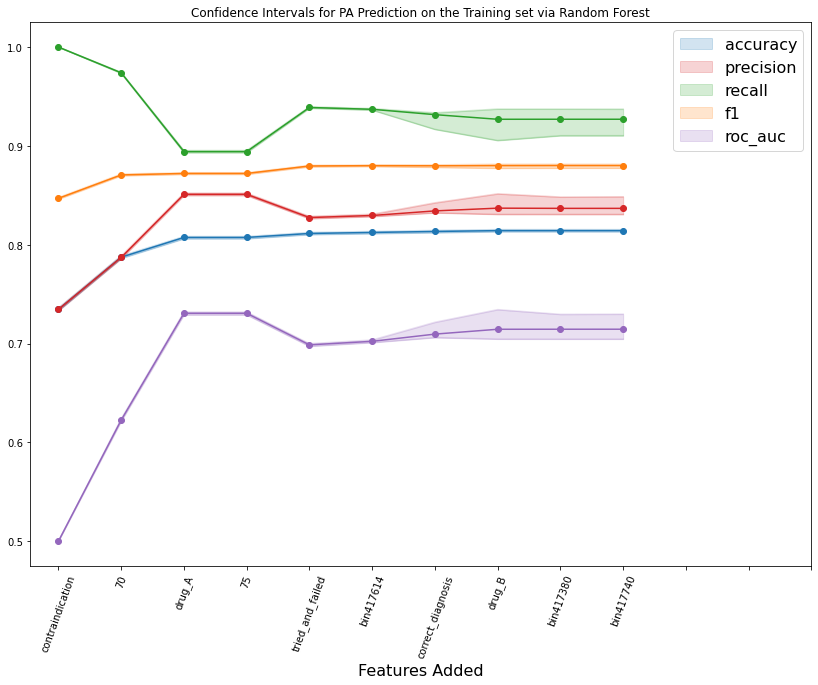

In [88]:
rf_b_ci=create_ci(rf_b_scores, alpha)
plot_ci(rf_b_ci, 'Random Forest', 'Training', rf_features)

The points on the above plot correspond to the median of the confidence interval and the opaque bars correspond to the endpoints of the interval. Intuitively, the narrower the shaded region about a point, the less variability there is in that score. 

The x-axis describes the features that are added. For example, the points in the column titled 'contraindication' correspond to the measures of performance for the random forest classifier trained on only the feature 'contraindication'. In the next column, titled '70', the points correspond to the measures of performance for the random forest classifier trained on the features ['contraindication', '70']. Thus, as we move from left to right on the $x$-axis, the training set accumulates features. 

We see that there is a significant amount of variability in the scores once $5$ or $6$ features are added.

In [85]:
rf_clf = RandomForestClassifier()
rf_o_scores=seq_oob_scores(rf_clf, rf_features, X_train_gen, y_train_gen)

iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
itera

In [400]:
rf_o_ci=create_ci(rf_o_scores, alpha)

We would like to know if there is a significant difference between the scores on the training set and the test set. Because we fixed the random state in the bootstrap splits, we can look at the difference between the scores and extract the largest values. 

In [409]:
print('The largest difference between the enpoints or middle of confidence intervals on the bootstrap training set and test set are:')
print()
print(rf_o_ci.drop(['score_type'], axis=1).subtract(rf_b_ci.drop(['score_type'], axis=1)).max())

The largest difference between the enpoints or middle of confidence intervals on the bootstrap training set and test set are:

lower_bound         0.001398
middle              0.000606
upper_bound         0.005663
model_complexity    0.000000
dtype: float64


Because these differences are small, we will focus on plotting the scores from the regular bootstrap samples. 

### Logistic Regression

In [57]:
log_reg = LogisticRegression()
log_b_scores=seq_bootstrapped_scores(log_reg, log_features, X_train_gen, y_train_gen)

iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iterati

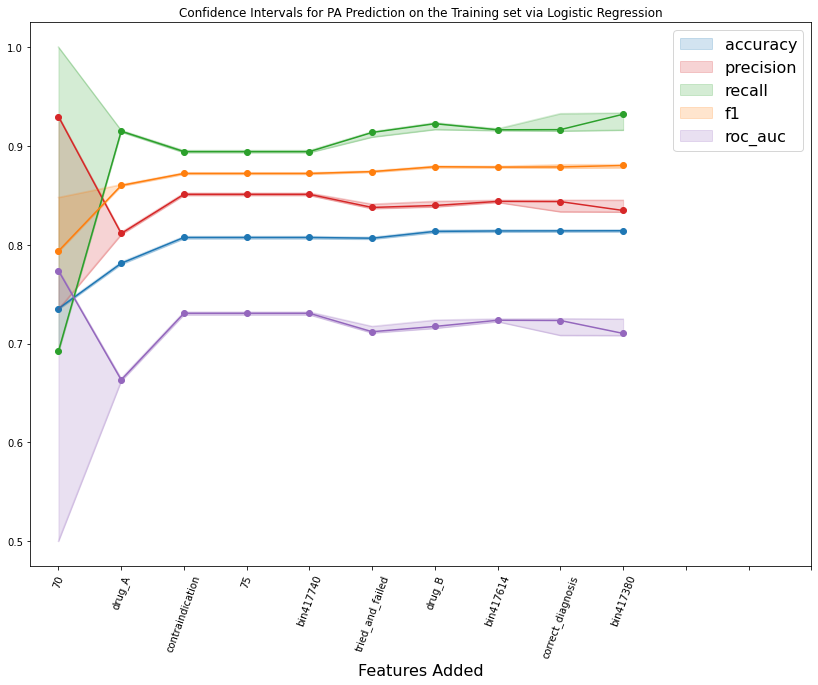

In [69]:
log_b_ci=create_ci(log_b_scores, alpha)
plot_ci(log_b_ci, 'Logistic Regression', 'Training', log_features)

The logistic regression classifier performs inconsistently when it is trained on only $1$ feature, which is not surprising. The measures of performance are very consistent until we add 'tried_and_failed' as a feature to the training data. Then recall, the area under the ROC curve and the precision have a larger variability. 

In [70]:
log_reg = LogisticRegression()
log_o_scores=seq_oob_scores(log_reg, log_features, X_train_gen, y_train_gen)

iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
itera

In [413]:
log_o_ci=create_ci(log_o_scores, alpha)

We can again check the difference between the midpoints and endpoints of the confidence intervals constructed for the test set and the training set. 

In [412]:
print('The largest difference between the endpoints or middle of confidence intervals on the bootstrap training set and test set are:')
print()
print(log_o_ci.drop(['score_type'], axis=1).subtract(log_b_ci.drop(['score_type'], axis=1)).max())

The largest difference between the endpoints or middle of confidence intervals on the bootstrap training set and test set are:

lower_bound         0.000187
middle              0.000216
upper_bound         0.001061
model_complexity    0.000000
dtype: float64


The differences are negligible, similar to the case of the random forest. 

### Support Vector Machine

In [72]:
svc = LinearSVC(penalty='l2', C=1)
svc_b_scores=seq_bootstrapped_scores(svc, svc_features, X_train_gen, y_train_gen)

iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iterati

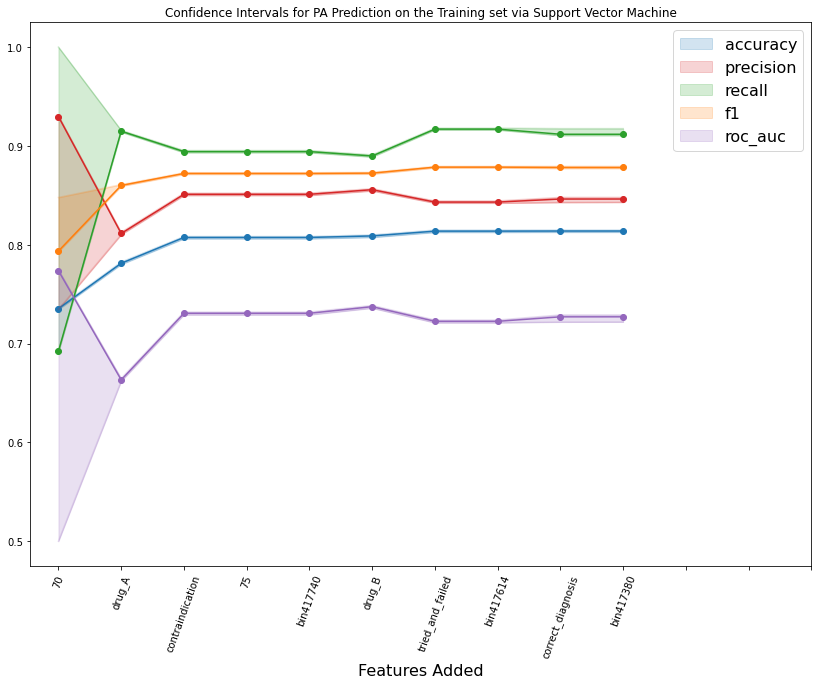

In [73]:
svc_b_ci=create_ci(svc_b_scores, alpha)
plot_ci(svc_b_ci, 'Support Vector Machine', 'Training', svc_features)

The linear support vector machine performs the most consistently of all the models we have looked at so far. We see that the performance is inconsistent when the classifier is trained only on the feature '70', corresponding to the reject code. Additionally, there is some  more variability once we add 8 features. 

We take a closer look below. 

In [418]:
svc_b_ci[(svc_b_ci['model_complexity']>8) & (svc_b_ci['score_type']=='roc_auc')]

,lower_bound,middle,upper_bound,model_complexity,score_type
4,0.721814,0.727054,0.729007,9.0,roc_auc
4,0.721879,0.727078,0.729007,10.0,roc_auc


Therefore, the width of these confidence intervals is about ~$0.008$ and is small. 

In [74]:
svc = LinearSVC(penalty='l2', C=1)
svc_o_scores=seq_oob_scores(svc, svc_features, X_train_gen, y_train_gen)

iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
itera

In [419]:
svc_o_ci=create_ci(svc_o_scores, alpha)

In [420]:
print('The largest difference between the endpoints or middle of confidence intervals on the bootstrap training set and test set are:')
print()
print(svc_o_ci.drop(['score_type'], axis=1).subtract(svc_b_ci.drop(['score_type'], axis=1)).max())

The largest difference between the endpoints or middle of confidence intervals on the bootstrap training set and test set are:

lower_bound         0.000000
middle              0.000181
upper_bound         0.001081
model_complexity    0.000000
dtype: float64


### Bayes Classifier

In [76]:
bayes_clf=GroupAverageClassifier()
bayes_b_scores=seq_bootstrapped_scores(bayes_clf, bayes_features, X_train_gen, y_train_gen)

iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iterati

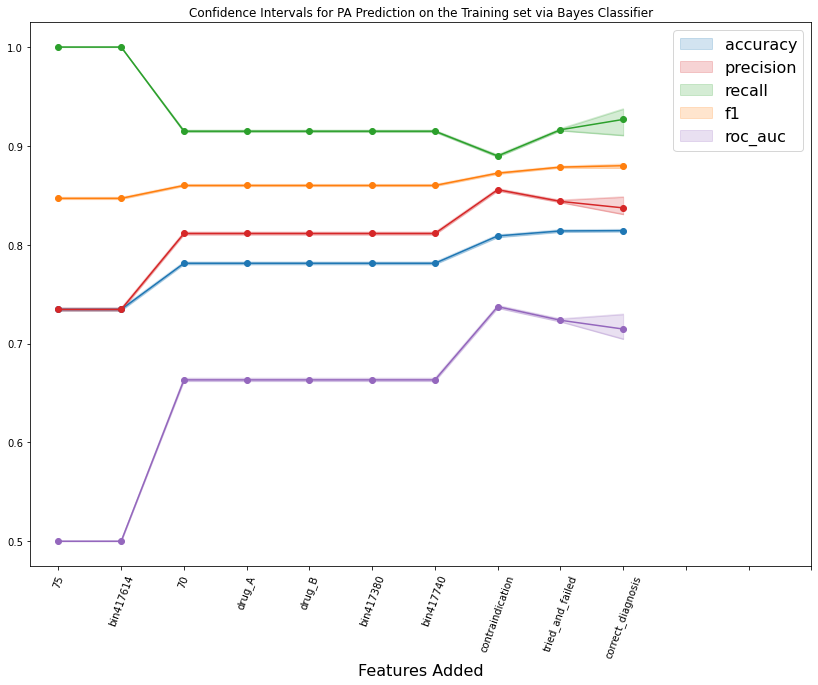

In [77]:
bayes_b_ci=create_ci(bayes_b_scores, alpha)
plot_ci(bayes_b_ci, 'Bayes Classifier', 'Training', bayes_features)

The Bayes classifier also performs consistently, with visible variation once the $10$th feature is added. We can take a closer look at these confidence intervals. 

In [421]:
bayes_b_ci[bayes_b_ci['model_complexity']==10]

,lower_bound,middle,upper_bound,model_complexity,score_type
0,0.813216,0.814295,0.815328,10.0,accuracy
1,0.830815,0.837297,0.848275,10.0,precision
2,0.910578,0.926787,0.937226,10.0,recall
3,0.877658,0.879946,0.881471,10.0,f1
4,0.704574,0.714717,0.729596,10.0,roc_auc


The width of the largest confidence interval is $~0.03$, which corresponds to $3$%. Depending on the tolerance for error, this quantity is likely to be significant. 

### AdaBoost

In [79]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
            n_estimators = 10,
            algorithm="SAMME.R",
            learning_rate = 0.5
        )
ada_b_scores=seq_bootstrapped_scores(ada_clf, ada_features, X_train_gen, y_train_gen)

iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iterati

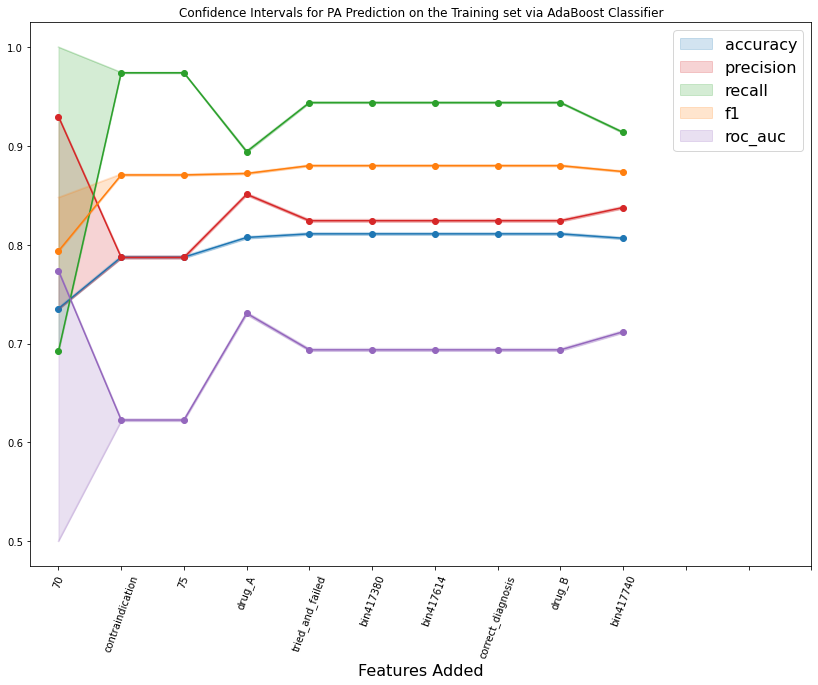

In [80]:
ada_b_ci=create_ci(ada_b_scores, alpha)
plot_ci(ada_b_ci, 'AdaBoost Classifier', 'Training', ada_features)

AdaBoost performs inconsistently with $10$ estimators on the feature '70', which corresponds to the reject code. However, once more features are added, the performance of the AdaBoost classifier stabilizes and becomes consistent.

In [81]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
            n_estimators = 10,
            algorithm="SAMME.R",
            learning_rate = 0.5
        )
ada_o_scores=seq_oob_scores(ada_clf, ada_features, X_train_gen, y_train_gen)

iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
itera

In [422]:
ada_o_ci=create_ci(ada_o_scores, alpha)

In [423]:
print('The largest difference between the endpoints or middle of confidence intervals on the bootstrap training set and test set are:')
print()
print(ada_o_ci.drop(['score_type'], axis=1).subtract(ada_b_ci.drop(['score_type'], axis=1)).max())

The largest difference between the endpoints or middle of confidence intervals on the bootstrap training set and test set are:

lower_bound         0.000000
middle              0.000185
upper_bound         0.001061
model_complexity    0.000000
dtype: float64


### Decision Tree 

In [96]:
dt_clf = DecisionTreeClassifier()
dt_b_scores=seq_bootstrapped_scores(dt_clf, dt_features, X_train_gen, y_train_gen)

iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iterati

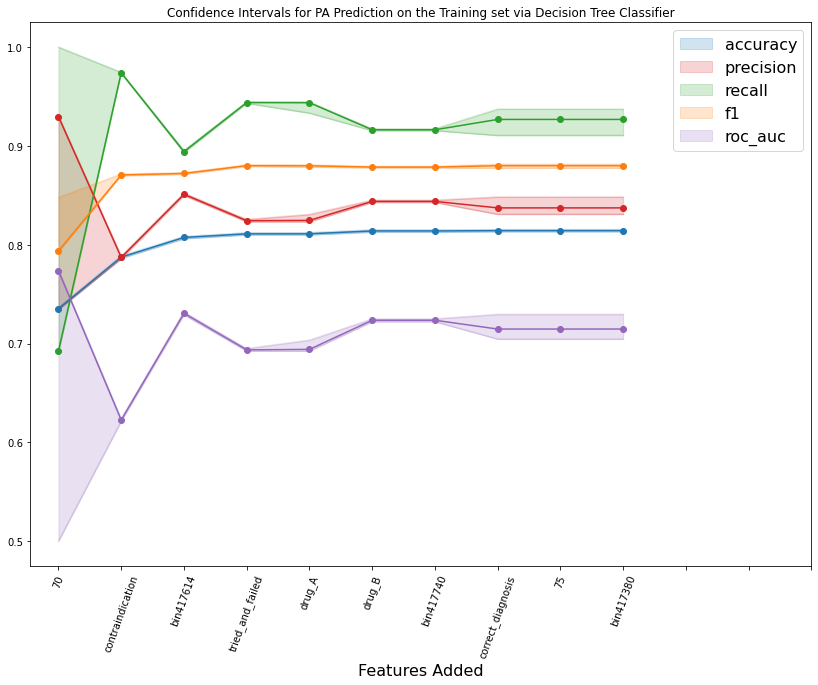

In [97]:
dt_b_ci=create_ci(dt_b_scores, alpha)
plot_ci(dt_b_ci, 'Decision Tree Classifier', 'Training', dt_features)

Unsurprisingly, the performance of the decision tree is similar to that of the random forest. 

Consider the following sequence combinations corresponding to the smallest confidence intervals:

In [427]:
print(dt_features[:2])
print(dt_features[:3])
print(dt_features[:4])
print(dt_features[:6])
print(dt_features[:7])

['70', 'contraindication']
['70', 'contraindication', 'bin417614']
['70', 'contraindication', 'bin417614', 'tried_and_failed']
['70', 'contraindication', 'bin417614', 'tried_and_failed', 'drug_A', 'drug_B']
['70', 'contraindication', 'bin417614', 'tried_and_failed', 'drug_A', 'drug_B', 'bin417740']


It is surprising that the following feature combination, gives more inconsistent results, given that the last two sets of features above contain it as a proper subset:

In [428]:
print(dt_features[:5])

['70', 'contraindication', 'bin417614', 'tried_and_failed', 'drug_A']


In [98]:
dt_clf = DecisionTreeClassifier()
dt_o_scores=seq_oob_scores(dt_clf, dt_features, X_train_gen, y_train_gen)

iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
itera

In [424]:
dt_o_ci=create_ci(dt_o_scores, alpha)

In [429]:
print('The largest difference between the endpoints or middle of confidence intervals on the bootstrap training set and test set are:')
print()
print(dt_o_ci.drop(['score_type'], axis=1).subtract(dt_b_ci.drop(['score_type'], axis=1)).max())

The largest difference between the endpoints or middle of confidence intervals on the bootstrap training set and test set are:

lower_bound         0.000000
middle              0.000185
upper_bound         0.003813
model_complexity    0.000000
dtype: float64


## Best of: Maximizing the ROC Score
We want to choose the model with the highest ROC score and an accuracy that is greater than $0.73$, since that is the accuracy of the baseline model that predicts all PAs will be approved.

### From the Bootstrap
First, we choose the models from the above discussion that maximize the ROC curve and plot the confidence intervals of the performance measures. 

In [175]:
# get the best model
rf_best=rf_b_ci[(rf_b_ci['score_type']=='roc_auc') & (rf_b_ci['model_complexity'] > 1)].sort_values(by='lower_bound', ascending=False).iloc[0]
log_best=log_b_ci[(log_b_ci['score_type']=='roc_auc') & (log_b_ci['model_complexity'] > 1)].sort_values(by='lower_bound', ascending=False).iloc[0]
bayes_best=bayes_b_ci[(bayes_b_ci['score_type']=='roc_auc')& (bayes_b_ci['model_complexity'] > 1) ].sort_values(by='lower_bound', ascending=False).iloc[0]
ada_best=ada_b_ci[(ada_b_ci['score_type']=='roc_auc') & (ada_b_ci['model_complexity'] > 1)].sort_values(by='lower_bound', ascending=False).iloc[0]
dt_best=dt_b_ci[(dt_b_ci['score_type']=='roc_auc') & (dt_b_ci['model_complexity'] > 1)].sort_values(by='lower_bound', ascending=False).iloc[0]
svc_best=svc_b_ci[(svc_b_ci['score_type']=='roc_auc') & (svc_b_ci['model_complexity'] > 1)].sort_values(by='lower_bound', ascending=False).iloc[0]

data=np.zeros((6,4))

data[0,:]=rf_best[0:4]
data[1,:]=log_best[0:4]
data[2,:]=bayes_best[0:4]
data[3,:]=ada_best[0:4]
data[4,:]=dt_best[0:4]
data[5,:]=svc_best[0:4]

In [176]:
# get the features from the best models 
best_feats=[]
best_feats.append(rf_features[:int(rf_best[3])])
best_feats.append(log_features[:int(log_best[3])])
best_feats.append(bayes_features[:int(bayes_best[3])])
best_feats.append(ada_features[:int(ada_best[3])])
best_feats.append(dt_features[:int(dt_best[3])])
best_feats.append(svc_features[:int(svc_best[3])])

We can now plot the ROC AUC score for each of the best models. 

FEATURES USED:

Random Forest:  ['contraindication', '70', 'drug_A']
Logistic Regression:  ['70', 'drug_A', 'contraindication']
Bayes Classifier:  ['75', 'bin417614', '70', 'drug_A', 'drug_B', 'bin417380', 'bin417740', 'contraindication']
AdaBoost:  ['70', 'contraindication', '75', 'drug_A']
Decision Tree:  ['70', 'contraindication', 'bin417614']
Linear Support Vector Machine:  ['70', 'drug_A', 'contraindication', '75', 'bin417740', 'drug_B']


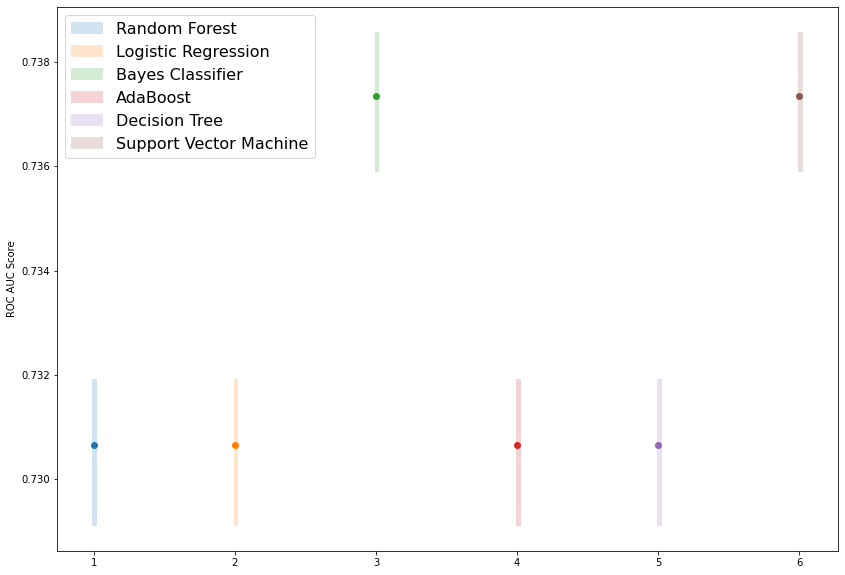

In [177]:
model_list=[ 'Random Forest','Logistic Regression', 'Bayes Classifier','AdaBoost', 'Decision Tree','Support Vector Machine']
x=range(1,len(model_list)+1)
fig, ax = plt.subplots(figsize=(14,10))

for i in x:
    ax.plot(i, data[i-1,1], 'o')
    vals=(i-.01, i+.025)
    ax.fill_between(vals, data[i-1,0], data[i-1,2], alpha=.2, label=model_list[i-1])

ax.set_ylabel('ROC AUC Score')

print('FEATURES USED:')
print()
print('Random Forest: ', best_feats[0])
print('Logistic Regression: ', best_feats[1])
print('Bayes Classifier: ', best_feats[2])
print('AdaBoost: ', best_feats[3])
print('Decision Tree: ', best_feats[4])
print('Linear Support Vector Machine: ', best_feats[5])

ax.legend(fontsize=16)

plt.show()

It is somewhat surprising that the confidence intervals are all of similar size and there seems to be a separation of the models into two groups. One contains the random forest, logistic regression, decision tree and AdaBoost while the other contains the Bayes classifier and the support vector machine. 

### From Fine Tuning with Feature Selection
Choosing to sequentially add features in order of importance does not necessarily yield in optimal results.  Therefore, we use the fine tuning done in PA_classifier.ipynb to choose our features and parameters. This notebook computes the measures of performance for each model using all possible feature combinations. The fine tuned features used below are found in the notebooks 'pa_classifier.ipynb' and 'feature_selection.ipynb'.

Note that because we use the previous functions written for confidence intervals in which the model complexity might be chaanging, we must include a model complexity value. We choose to set 'model_complexity'=1, but this is a dummy variable and has no significance. 

#### Random Forest
We first train the classifier on the optimal set of features. 

In [222]:
fine_tune_rf_feats=['70', '75', 'bin417380','bin417740', 'bin417614','correct_diagnosis', 'tried_and_failed', 'drug_A', 'drug_B']

rf_clf= RandomForestClassifier(criterion= 'gini', max_depth = 7, min_samples_split= 2, n_estimators=15)
rf_best_boot=get_bootstrapped_scores(rf_clf, X_train_gen[fine_tune_rf_feats], y_train)

iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90


The confidence intervals for the scores are given below.

In [262]:
rf_best_ci=create_ci(rf_best_boot, alpha=.95)
rf_best_ci['model_name']='Random Forest'
rf_best_ci

,lower_bound,middle,upper_bound,model_complexity,score_type,model_name
0,0.784275,0.785283,0.786440,1.0,accuracy,Random Forest
1,0.810640,0.877684,0.879040,1.0,precision,Random Forest
2,0.820654,0.822106,0.925226,1.0,recall,Random Forest
3,0.848378,0.849262,0.863982,1.0,f1,Random Forest
4,0.662864,0.752724,0.754333,1.0,roc_auc,Random Forest


#### Decision Tree 
We first train the decision tree on the optimal features. Note that this set of features corresponds to the set of features used for the random forest. 

In [265]:
fine_tune_dt_feats=['70', '75', 'bin417380','bin417740', 'bin417614','correct_diagnosis', 'tried_and_failed', 'drug_A', 'drug_B']

dt_clf= DecisionTreeClassifier(criterion= 'gini', max_depth = 7, min_samples_split= 2)
dt_best_boot=get_bootstrapped_scores(dt_clf, X_train_gen[fine_tune_dt_feats], y_train)

iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90


In [266]:
dt_best_boot['model_complexity']=1
dt_best_ci=create_ci(dt_best_boot, alpha=.95)
dt_best_ci['model_name']='Decision Tree'

In [264]:
dt_best_ci

,lower_bound,middle,upper_bound,model_complexity,score_type,model_name
0,0.784338,0.785299,0.786474,1.0,accuracy,Decision Tree
1,0.817087,0.877805,0.879551,1.0,precision,Decision Tree
2,0.820062,0.821803,0.912425,1.0,recall,Decision Tree
3,0.848253,0.849175,0.862484,1.0,f1,Decision Tree
4,0.672394,0.752835,0.754757,1.0,roc_auc,Decision Tree


#### Linear Support Vector Machine
We train the linear support vector machine on its best features for the ROC curve as well and find the confidence intervals. 

In [230]:
fine_tune_svc_feats=['70', '75', 'bin417614', 'tried_and_failed', 'drug_B']
svc_clf = LinearSVC(C=1)
svc_best_boot=get_bootstrapped_scores(svc_clf, X_train_gen[fine_tune_svc_feats], y_train)
svc_best_boot['model_complexity']=1
svc_best_ci=create_ci(svc_best_boot, alpha=.95)

iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90


In [267]:
svc_best_ci['model_name']='Support Vector Machine'
svc_best_ci

,lower_bound,middle,upper_bound,model_complexity,score_type,model_name
0,0.783960,0.785228,0.786291,1.0,accuracy,Support Vector Machine
1,0.876854,0.877967,0.879111,1.0,precision,Support Vector Machine
2,0.820695,0.821737,0.823000,1.0,recall,Support Vector Machine
3,0.848113,0.848985,0.849760,1.0,f1,Support Vector Machine
4,0.751377,0.752889,0.754080,1.0,roc_auc,Support Vector Machine


#### Logistic Regression 
We train the logistic regression model on its best features. 

In [374]:
fine_tune_log_feats=['70', 'bin417614', 'tried_and_failed', 'drug_B']
log_clf = LogisticRegression()
log_best_boot=get_bootstrapped_scores(log_clf, X_train_gen[fine_tune_log_feats], y_train)
log_best_boot['model_complexity']=1

log_best_ci=create_ci(log_best_boot, alpha=.95)

iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90


In [375]:
log_best_ci['model_name']='Logistic Regression'
log_best_ci

,lower_bound,middle,upper_bound,model_complexity,score_type,model_name
0,0.783960,0.785228,0.786291,1.0,accuracy,Logistic Regression
1,0.876854,0.877967,0.879111,1.0,precision,Logistic Regression
2,0.820695,0.821737,0.823000,1.0,recall,Logistic Regression
3,0.848113,0.848985,0.849760,1.0,f1,Logistic Regression
4,0.751377,0.752889,0.754080,1.0,roc_auc,Logistic Regression


#### AdaBoost 

In [295]:
#fine_tune_ada_feats=['70', '75', 'drug_B']
fine_tune_ada_feats=['70', '75', 'bin417380', 'contraindication', 'drug_A', 'drug_B']
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
            n_estimators = 10,
            algorithm="SAMME.R",
            learning_rate = 0.5
        )

ada_best_boot=get_bootstrapped_scores(ada_clf, X_train_gen[fine_tune_ada_feats], y_train)
ada_best_boot['model_complexity']=1
ada_best_ci=create_ci(ada_best_boot, alpha=.95)


iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90


In [343]:
ada_best_ci['model_name']='AdaBoost'

#### Bayes Classifier
Lastly, we train the Bayes classifier on its optimal set of features. It is interesting to note that 'contraindication' only appears in the feature list for AdaBoost. This seems interesting because this feature corresponds to whether the treatment could be harmful to the patient, which seems important. 

In [233]:
fine_tune_bayes_feats=['75', 'bin417380', 'bin417740', 'bin417614', 'tried_and_failed', 'drug_B']
bayes_clf=GroupAverageClassifier()

bayes_best_boot=get_bootstrapped_scores(bayes_clf, X_train_gen[fine_tune_bayes_feats], y_train)
bayes_best_boot['model_complexity']=1
bayes_best_ci=create_ci(bayes_best_boot, alpha=.95)


iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90


In [287]:
bayes_best_ci['model_name']='Bayes Classifier'

#### Plotting the Results
First we collect all of our results into a single data frame. 

In [376]:
N = 6 # number of models
ci_list=[rf_best_ci, dt_best_ci, log_best_ci, svc_best_ci, ada_best_ci, bayes_best_ci]

df=rf_best_ci.append(dt_best_ci).append(log_best_ci).append(svc_best_ci).append(ada_best_ci).append(bayes_best_ci)

Now we can plot our results. 

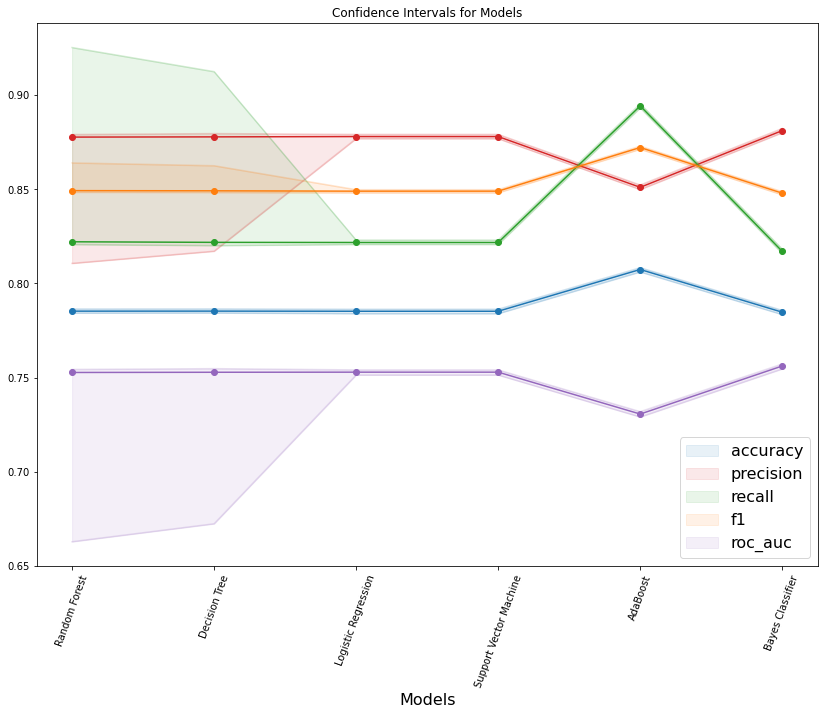

In [345]:
fig, ax = plt.subplots(figsize=(14,10))

model_names=['Random Forest', 'Decision Tree', 'Logistic Regression','Support Vector Machine', 'AdaBoost', 'Bayes Classifier']

colors=['tab:blue', 'tab:red', 'tab:green', 'tab:orange', 'tab:purple']

for i,j in enumerate(default_names):
    
    data=df[df['score_type']==j]
    midvals=np.array(data[['middle']])
    ub=np.array(data[['upper_bound']])
    lb=np.array(data[['lower_bound']])
    ax.plot(model_names, np.reshape(midvals,(-1,)), 'o-', color=colors[i])
    ax.plot(model_names, np.reshape(ub,(-1,)), '-',alpha=.2, color=colors[i])
    ax.plot(model_names, np.reshape(lb,(-1,)), '-',alpha=.2, color=colors[i])
    ax.fill_between(model_names, np.reshape(lb,(-1,)), np.reshape(ub,(-1,)), alpha=.1, label=j, color=colors[i])

    #ax.fill_between(x, np.reshape(lb,(-1,)), np.reshape(ub,(-1,)), alpha=.2, label=j, step='mid')
    #ax.plot(x, np.reshape(midvals,(-1,)), 'o')
ax.set_xlabel("Models",fontsize=16)
ax.set_title('Confidence Intervals for Models')
ax.tick_params(axis='x', rotation=70)
#ax.set_xticklabels(model_names)


ax.legend(fontsize=16)

plt.show()

From this plot we see that the decision tree and the random forest have the largest confidence intervals for the ROC curve, the precision, and the f1 score. The other models have visible confidence intervals as well, but they are smaller. 

We can look at just a few of the scores types to get a better understanding of what is going on. 

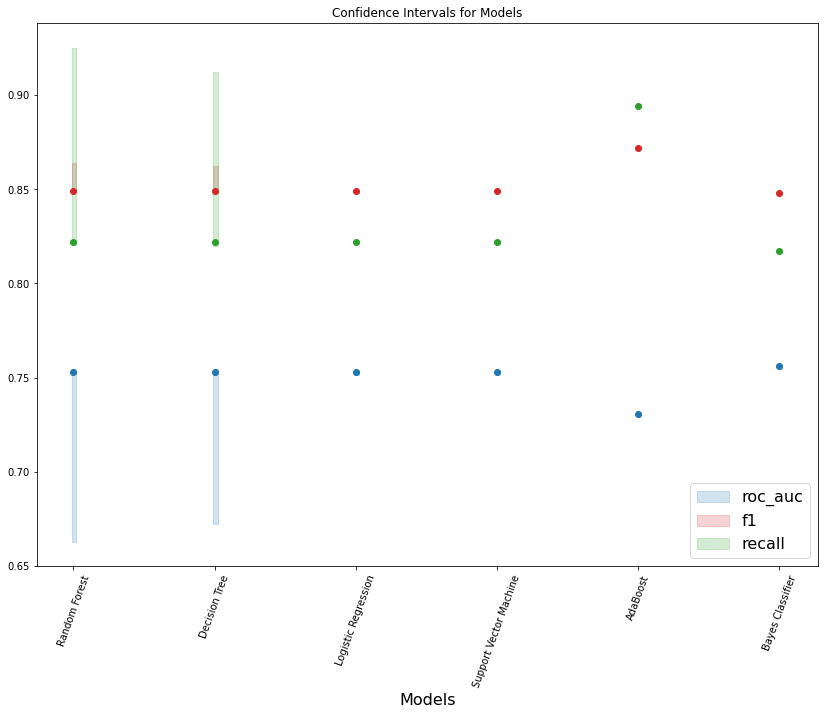

In [377]:
fig, ax = plt.subplots(figsize=(14,10))

model_names=['Random Forest', 'Decision Tree', 'Logistic Regression','Support Vector Machine', 'AdaBoost', 'Bayes Classifier']

colors=['tab:blue', 'tab:red', 'tab:green', 'tab:orange', 'tab:purple']

custom_names=['roc_auc', 'f1','recall']


for x, name in enumerate(model_names):
    model_data=df[df['model_name']==name]
    for i,j in enumerate(custom_names):
        data=model_data[model_data['score_type']==j]
        midvals=np.array(data[['middle']])
        ub=np.array(data[['upper_bound']])
        lb=np.array(data[['lower_bound']])
        ax.plot(x, np.reshape(midvals,(-1,)), 'o-', color=colors[i])
        interval=(x-.01, x+.02)
        if x == 0:
            ax.fill_between(interval, np.reshape(lb,(-1,)), np.reshape(ub,(-1,)), 
                            alpha=.2, label=j, color=colors[i])
        else:
            ax.fill_between(interval, np.reshape(lb,(-1,)), np.reshape(ub,(-1,)), 
                            alpha=.2, color=colors[i])

ax.set_xlabel("Models",fontsize=16)
ax.set_title('Confidence Intervals for Models')
ax.tick_params(axis='x', rotation=70)
ax.set_xticks(range(0,N))
ax.set_xticklabels(model_names)


ax.legend(fontsize=16, loc='lower right')

#plt.show()
plt.savefig('conf_inf2.pdf', bbox_inches='tight')

Finally, we can represent each score on its own plot. 

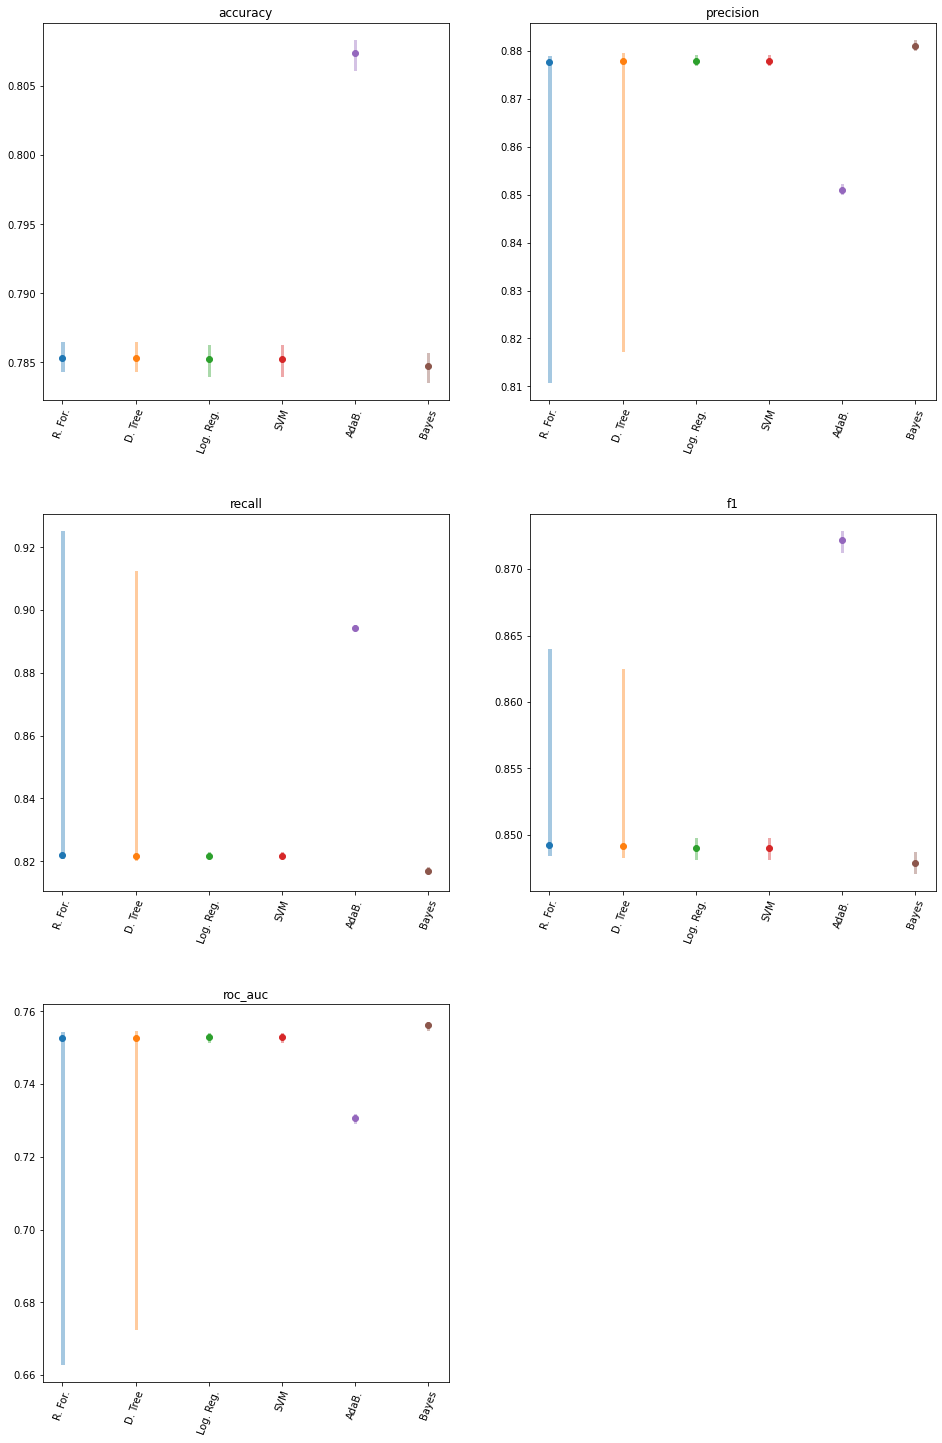

In [346]:
abbr_names=['R. For.','D. Tree', 'Log. Reg.', 'SVM','AdaB.','Bayes']
fig, axs = plt.subplots(3,2, figsize=(16,25))

for j in range(0,2):
    for k in range(0,3):
        if 2*k+j==5: 
            fig.delaxes(axs[k,j])
        else:    
            score=default_names[2*k+j]
            data=df[df['score_type']==score]
            x = range(0, N)
            for i in x:
                axs[k,j].plot(i, np.array(data['middle'])[i], 'o')
                vals=(i-.015, i+.03)
                axs[k,j].fill_between(vals, np.array(data['lower_bound'])[i], np.array(data['upper_bound'])[i], alpha=.4, label=model_list[i-1], joinstyle='round')

            axs[k,j].set_xticks(range(0,N))
            axs[k,j].set_xticklabels(abbr_names)
            axs[k,j].tick_params(axis='x', rotation=70)
            axs[k,j].set_title(default_names[2*k+j])
plt.subplots_adjust(hspace=0.3, wspace=0.2)



##### Conclusion 
First notice that the random forest and decision tree perform consistently better in the ROC score than AdaBoost. Since the solid dot represents the middle of the confidence interval, the above plot tells us that the random forest and decision tree outperform AdaBoost with respect to this metric more than $50$% of the time. Furthermore, the confidence intervals for the random forest and decision tree corresponding to recall and f score have a lower bound and median that is similar to that of the other models, but the upper bound is larger. Therefore, the random forest and decision tree models seem to be the best from this analysis. 

Finally, the permuation importance and drop feature importance allow us to conclude that the random forest is the best classifier. See pa_classifier_feature_importance.ipynb.

